In [1]:
%load_ext autoreload
%autoreload 2

import os
from os import path
import sys
cwd = os.getcwd().split(os.path.sep)

# point to the git repository
while cwd[-1] != "ExplanationPairSentencesTasks":
    os.chdir("..")
    cwd = os.getcwd().split(os.path.sep)
print(f">> current directory : {os.getcwd()}")

# add the root directory
sys.path.append(os.path.join(os.getcwd(), "src"))

# cache and data cache
cache_path = path.join(os.getcwd() ,'.cache')
dataset_path = path.join(cache_path, 'dataset')
log_path = path.join(cache_path, 'logs')
model_path = path.join(cache_path, 'models')
print(f">> cache path : {cache_path}")
print(f">> model path : {model_path}")
print(f">> dataset path : {dataset_path}")
print(f">> logs path : {log_path}")

# import the different modules
from src.data_module.hatexplain import CLSTokenHateXPlainDM
from src.data_module.esnli import CLSTokenESNLIDM
from src.data_module.yelp_hat import CLSTokenYelpHat50DM, CLSTokenYelpHatDM
from pur_attention_key_reg import AttitModel
from notebooks.attention_based.utils.ckp_config import *

# external librairies
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from tqdm.notebook import tqdm

from modules.metrics.geometry import cosine_sim, effective_rank

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f">> device : {DEVICE}")

>> current directory : C:\Users\loicf\Documents\IRISA\ExplanationPairSentencesTasks
>> cache path : C:\Users\loicf\Documents\IRISA\ExplanationPairSentencesTasks\.cache
>> model path : C:\Users\loicf\Documents\IRISA\ExplanationPairSentencesTasks\.cache\models
>> dataset path : C:\Users\loicf\Documents\IRISA\ExplanationPairSentencesTasks\.cache\dataset
>> logs path : C:\Users\loicf\Documents\IRISA\ExplanationPairSentencesTasks\.cache\logs
>> device : cuda


In [2]:
reg_params = [0, 1, 2, 4, 6]

# HateXplain

In [3]:
%%capture
sim_k_dict = {
    f"lambda={i}" : 0 for i in reg_params
}
sim_v_dict = {
    f"lambda={i}" : 0 for i in reg_params
}

dm_kwargs = dict(cache_path=dataset_path,
                 batch_size=32,
                 num_workers=0,
                 n_data=999
                 )

dm = CLSTokenHateXPlainDM(**dm_kwargs)

dm.prepare_data()
dm.setup(stage="test")
test_dataloader = dm.test_dataloader() # load the test dataset

spec_ids = torch.tensor(dm.vocab(["<cls>", "<pad>", "<unk>"]), device=DEVICE)

model_args = dict(
        cache_path=model_path,
        mode="exp",
        vocab=dm.vocab,
        lambda_entropy=0,
        lambda_supervise=0,
        lambda_lagrange=0,
        pretrained_vectors="glove.840B.300d",
        num_layers=1,
        num_heads=1,
        d_embedding=300,
        data="hatexplain",
        num_class=dm.num_class,
        opt="adam"
)

for i in reg_params :

    ckp = os.path.join(log_path, "PurAttentionReg", f"entropy_reg_hatexplain_lbd={i}", "checkpoints", "best.ckpt")
    hparams = os.path.join(log_path, "PurAttentionReg", f"entropy_reg_hatexplain_lbd={i}", "hparams.yaml")

    # the model
    model = AttitModel.load_from_checkpoint(ckp, hparams_file=hparams, **model_args)
    model = model.eval()

    with torch.no_grad():
        model = model.to(DEVICE)
        pbar = tqdm(enumerate(test_dataloader), total = int(999/32))
        for id_batch, batch in pbar:

            pbar.set_description("proceed the similarity metric")
            ids = batch["token_ids"].to(DEVICE)

            # PADDING
            padding_mask = batch["padding_mask"].bool().to(DEVICE)
            buff_mask = torch.isin(ids, spec_ids)
            embedding_padding = padding_mask.clone()
            embedding_padding[buff_mask] = 1.

            # OUTPUTS
            output = model(ids=ids, mask=padding_mask)

            k, v, emb = output["key_embeddings"], output["value_embeddings"], output["hidden_states"]

            sim_k = cosine_sim(k[0], padding_mask, normalize="")
            sim_v = cosine_sim(v[0], padding_mask, normalize="")

            # update dictionnaries
            sim_k_dict[f"lambda={i}"] += sim_k.sum().item()
            sim_v_dict[f"lambda={i}"]+= sim_v.sum().item()

    model = model.cpu()
    del model
    torch.cuda.empty_cache()

for k in sim_k_dict:
    sim_k_dict[k] = sim_k_dict[k] / dm.n_data
    sim_v_dict[k] = sim_v_dict[k] / dm.n_data
;

In [4]:
for k in sim_k_dict:
    print(k, ":", sim_k_dict[k])

lambda=0 : 0.745360366813652
lambda=1 : 0.5519730266746696
lambda=2 : 0.5592802270158036
lambda=4 : 0.46210975188750764
lambda=6 : 0.4592474301656087


In [5]:
for k in sim_v_dict:
    print(k, ":", sim_v_dict[k])

lambda=0 : 0.5778044064839681
lambda=1 : 0.5200517516475063
lambda=2 : 0.6888904905653334
lambda=4 : 0.6777643264831604
lambda=6 : 0.47847652769422866


''

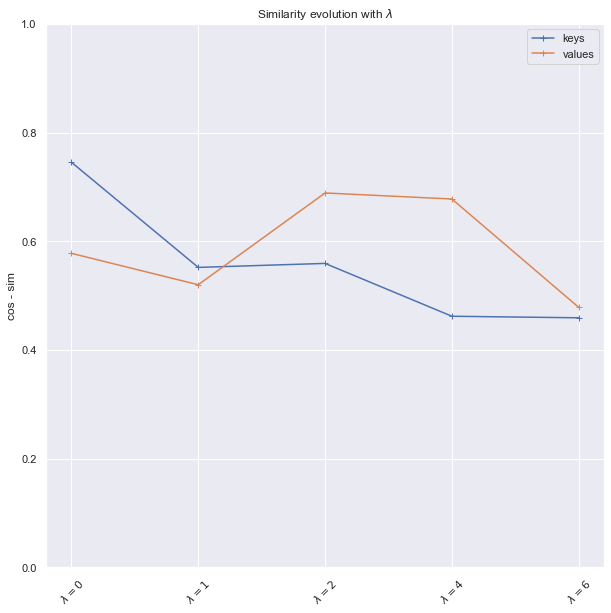

In [6]:
# the corresponding graphic
figure = plt.figure(figsize=(10, 10))
plt.plot(list(range(len(sim_k_dict))), list(sim_k_dict.values()), "+-", label="keys")
plt.plot(list(range(len(sim_v_dict))), list(sim_v_dict.values()), "+-", label="values")
plt.ylim(0, 1)
plt.legend()
plt.ylabel("cos - sim")
plt.title("Similarity evolution with $\lambda$")
#plt.xlabel("$\lambda$")
ax = plt.gca()
ax.set_xticks(list(range(len(sim_k_dict))))
labels = [f"$\lambda = {x}$" for x in reg_params]
ax.set_xticklabels(labels, rotation=45)
plt.savefig(os.path.join(cache_path, "fig", "reg_geometry", "reg_geometry_hatexplain.png"))
;

# YelpHat

In [7]:
%%capture
sim_k_dict = {
    f"lambda={i}" : 0 for i in reg_params
}
sim_v_dict = {
    f"lambda={i}" : 0 for i in reg_params
}

dm_kwargs = dict(cache_path=dataset_path,
                 batch_size=32,
                 num_workers=0,
                 n_data=300
                 )

dm = CLSTokenYelpHat50DM(**dm_kwargs)

dm.prepare_data()
dm.setup(stage="test")
test_dataloader = dm.test_dataloader() # load the test dataset

spec_ids = torch.tensor(dm.vocab(["<cls>", "<pad>", "<unk>"]), device=DEVICE)

model_args = dict(
        cache_path=model_path,
        mode="exp",
        vocab=dm.vocab,
        lambda_entropy=0,
        lambda_supervise=0,
        lambda_lagrange=0,
        pretrained_vectors="glove.840B.300d",
        num_layers=1,
        num_heads=1,
        d_embedding=300,
        data="yelphat50",
        num_class=dm.num_class,
        opt="adam"
)

for i in reg_params :

    ckp = os.path.join(log_path, "PurAttentionReg", f"entropy_reg_yelphat50_lbd={i}", "checkpoints", "best.ckpt")
    hparams = os.path.join(log_path, "PurAttentionReg", f"entropy_reg_yelphat50_lbd={i}", "hparams.yaml")

    # the model
    model = AttitModel.load_from_checkpoint(ckp, hparams_file=hparams, **model_args)
    model = model.eval()

    with torch.no_grad():
        model = model.to(DEVICE)
        pbar = tqdm(enumerate(test_dataloader), total = int(999/32))
        for id_batch, batch in pbar:

            pbar.set_description("proceed the similarity metric")
            ids = batch["token_ids"].to(DEVICE)

            # PADDING
            padding_mask = batch["padding_mask"].bool().to(DEVICE)
            buff_mask = torch.isin(ids, spec_ids)
            embedding_padding = padding_mask.clone()
            embedding_padding[buff_mask] = 1.

            # OUTPUTS
            output = model(ids=ids, mask=padding_mask)

            k, v, emb = output["key_embeddings"], output["value_embeddings"], output["hidden_states"]

            sim_k = cosine_sim(k[0], padding_mask, normalize="")
            sim_v = cosine_sim(v[0], padding_mask, normalize="")

            # update dictionnaries
            sim_k_dict[f"lambda={i}"] += sim_k.sum().item()
            sim_v_dict[f"lambda={i}"]+= sim_v.sum().item()

    model = model.cpu()
    del model
    torch.cuda.empty_cache()

for k in sim_k_dict:
    sim_k_dict[k] = sim_k_dict[k] / dm.n_data
    sim_v_dict[k] = sim_v_dict[k] / dm.n_data
;

In [8]:
sim_k_dict

{'lambda=0': 0.5976478163401285,
 'lambda=1': 0.509263919989268,
 'lambda=2': 0.5096314263343811,
 'lambda=4': 0.4310096271832784,
 'lambda=6': 0.4527462871869405}

In [9]:
sim_v_dict

{'lambda=0': 0.42626859188079835,
 'lambda=1': 0.5858618179957072,
 'lambda=2': 0.6262212642033895,
 'lambda=4': 0.605236177444458,
 'lambda=6': 0.5403413303693135}

''

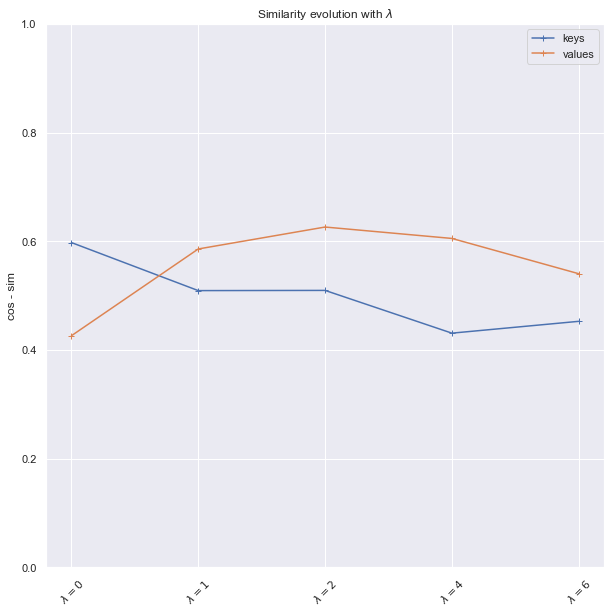

In [10]:
# the corresponding graphic
figure = plt.figure(figsize=(10, 10))
plt.plot(list(range(len(sim_k_dict))), list(sim_k_dict.values()), "+-", label="keys")
plt.plot(list(range(len(sim_v_dict))), list(sim_v_dict.values()), "+-", label="values")
plt.ylim(0, 1)
plt.legend()
plt.ylabel("cos - sim")
plt.title("Similarity evolution with $\lambda$")
#plt.xlabel("$\lambda$")
ax = plt.gca()
ax.set_xticks(list(range(len(sim_k_dict))))
labels = [f"$\lambda = {x}$" for x in reg_params]
ax.set_xticklabels(labels, rotation=45)
plt.savefig(os.path.join(cache_path, "fig", "reg_geometry", "reg_geometry_yelphat.png"))
;

# E-SNLI

In [11]:
%%capture
sim_k_dict = {
    f"lambda={i}" : 0 for i in reg_params
}
sim_v_dict = {
    f"lambda={i}" : 0 for i in reg_params
}

dm_kwargs = dict(cache_path=dataset_path,
                 batch_size=32,
                 num_workers=0,
                 n_data=999
                 )

dm = CLSTokenESNLIDM(**dm_kwargs)

dm.prepare_data()
dm.setup(stage="test")
test_dataloader = dm.test_dataloader() # load the test dataset

spec_ids = torch.tensor(dm.vocab(["<cls>", "<pad>", "<unk>"]), device=DEVICE)

model_args = dict(
        cache_path=model_path,
        mode="exp",
        vocab=dm.vocab,
        lambda_entropy=0,
        lambda_supervise=0,
        lambda_lagrange=0,
        pretrained_vectors="glove.840B.300d",
        num_layers=1,
        num_heads=1,
        d_embedding=300,
        data="esnli",
        num_class=dm.num_class,
        opt="adam"
)

for i in reg_params :

    ckp = os.path.join(log_path, "PurAttentionReg", f"entropy_reg_esnli_lbd={i}", "checkpoints", "best.ckpt")
    hparams = os.path.join(log_path, "PurAttentionReg", f"entropy_reg_esnli_lbd={i}", "hparams.yaml")

    # the model
    model = AttitModel.load_from_checkpoint(ckp, hparams_file=hparams, **model_args)
    model = model.eval()

    with torch.no_grad():
        model = model.to(DEVICE)
        pbar = tqdm(enumerate(test_dataloader), total = int(999/32))
        for id_batch, batch in pbar:

            pbar.set_description("proceed the similarity metric")
            ids = batch["token_ids"].to(DEVICE)

            # PADDING
            padding_mask = batch["padding_mask"].bool().to(DEVICE)
            buff_mask = torch.isin(ids, spec_ids)
            embedding_padding = padding_mask.clone()
            embedding_padding[buff_mask] = 1.

            # OUTPUTS
            output = model(ids=ids, mask=padding_mask)

            k, v, emb = output["key_embeddings"], output["value_embeddings"], output["hidden_states"]

            sim_k = cosine_sim(k[0], padding_mask, normalize="")
            sim_v = cosine_sim(v[0], padding_mask, normalize="")

            # update dictionnaries
            sim_k_dict[f"lambda={i}"] += sim_k.sum().item()
            sim_v_dict[f"lambda={i}"]+= sim_v.sum().item()

    model = model.cpu()
    del model
    torch.cuda.empty_cache()

for k in sim_k_dict:
    sim_k_dict[k] = sim_k_dict[k] / dm.n_data
    sim_v_dict[k] = sim_v_dict[k] / dm.n_data
;

In [12]:
sim_k_dict

{'lambda=0': 0.6735863766751371,
 'lambda=1': 0.11375479034714035,
 'lambda=2': 0.08114713830155534,
 'lambda=4': 0.10523046900679518,
 'lambda=6': 0.18206116518339477}

''

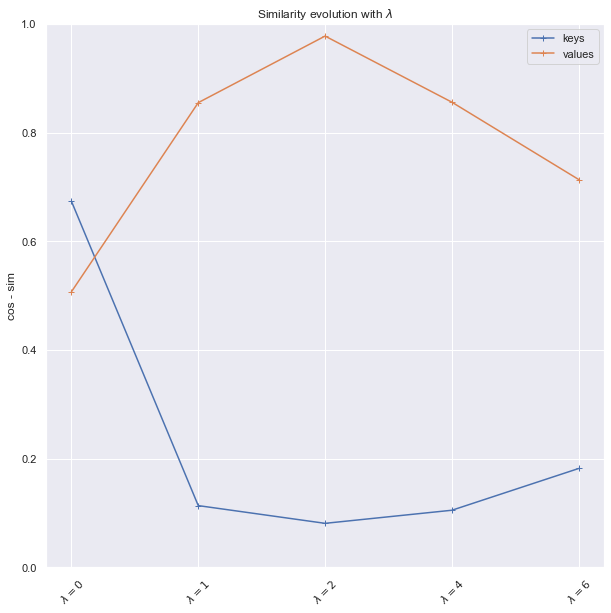

In [13]:
# the corresponding graphic
figure = plt.figure(figsize=(10, 10))
plt.plot(list(range(len(sim_k_dict))), list(sim_k_dict.values()), "+-", label="keys")
plt.plot(list(range(len(sim_v_dict))), list(sim_v_dict.values()), "+-", label="values")
plt.ylim(.0, 1)
plt.legend()
plt.ylabel("cos - sim")
plt.title("Similarity evolution with $\lambda$")
#plt.xlabel("$\lambda$")
ax = plt.gca()
ax.set_xticks(list(range(len(sim_k_dict))))
labels = [f"$\lambda = {x}$" for x in reg_params]
ax.set_xticklabels(labels, rotation=45)
plt.savefig(os.path.join(cache_path, "fig", "reg_geometry", "reg_geometry_esnli.png"))
;